In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import cvlib as cv
import pandas as pd
import os
from cvlib.object_detection import draw_bbox
import datetime
from ipywidgets import *

Using TensorFlow backend.


In [82]:
class ImageFile(object):
    """A file that is a picture of droplets

    Attributes:
        path: The location of the file
        name: the file name
    """

    def __init__(self, path, name):
        """Returns an ImageFile object"""
        self.path = path
        self.name = name
        self.list_of_droplets = []
        self.creation_time = datetime.datetime.now().isoformat()
        self.list_of_droplets = []
        self.list_of_edge_droplets = []
        self.contains_droplets = None

        # The zero means that it will load in grayscale only
        file_to_open = '{0}/{1}'.format(self.path, self.name)

        # print(file_to_open)
        self.in_img = cv2.imread(file_to_open)
        self.in_img_gray = cv2.cvtColor(
            self.in_img, cv2.COLOR_BGR2GRAY)  # grayscale concversion

        self.height, self.width = self.in_img_gray.shape

        self.status_string = ''

    def __repr__(self):
        return "ImageFile()"

    def __str__(self):
        return str(vars(self))

    def find_droplets(self, method='HOUGH'):
        """Find the position of droplets
        defaulting to the HoughCircles method from OpenCV2
        """
        param1 = 80
        param2 = 20
        minRadius = 10
        maxRadius = 50

        self.extra_radius = 3  # for saving extra space around, also for checks

        try:
            circles = cv2.HoughCircles(self.in_img_gray,
                                       cv2.HOUGH_GRADIENT,
                                       1,
                                       120,
                                       param1=param1,
                                       param2=param2,
                                       minRadius=minRadius,
                                       maxRadius=maxRadius)
            circles = np.uint16(np.around(circles))
            self.contains_droplets = True

            x_positions = circles[0, :, 0]
            y_positions = circles[0, :, 1]
            radii = circles[0, :, 2]

            cut_from = self.in_img.copy()

            edge_droplet_count = 0

            for circle_index, value in enumerate(x_positions):
                x_pos = x_positions[circle_index]
                y_pos = y_positions[circle_index]
                radius = radii[circle_index]

                too_left = x_pos-self.extra_radius*radius < 0
                too_right = x_pos+self.extra_radius*radius > self.width
                too_high = y_pos-self.extra_radius*radius < 0
                too_low = y_pos+self.extra_radius*radius > self.height
                if too_left or too_right or too_high or too_low:
                    # print('Droplet too close to edge')
                    edge_droplet = True
                    edge_droplet_count = edge_droplet_count + 1

                else:
                    edge_droplet = False

                if circle_index > -1 and edge_droplet == False:
                    '''
                    Good droplet
                    '''
                    # image_i=cut_from[x_pos:radius,y_pos:radius]
                    image_i = cut_from[y_pos - radius*self.extra_radius:
                                       y_pos + radius*self.extra_radius,
                                       x_pos - radius*self.extra_radius:
                                       x_pos + radius*self.extra_radius]

                    droplet = DropletImage(
                        original_image_path=self.path,
                        original_image_name=self.path,
                        path=self.path+'/Cuts',
                        image=image_i,
                        id_number=circle_index,
                        position=(x_pos, y_pos),
                        radius=radius, drop_type=None, edge_droplet=edge_droplet)
                    self.list_of_droplets.append(droplet)

                if circle_index > -1 and edge_droplet == True:
                    '''
                    Edge droplet
                    '''
                    droplet = DropletImage(
                        original_image_path=self.path,
                        original_image_name=self.path,
                        path=self.path+'/Cuts',
                        image=None,
                        id_number=circle_index,
                        position=(x_pos, y_pos),
                        radius=radius, drop_type=None, edge_droplet=edge_droplet)
                    self.list_of_edge_droplets.append(droplet)

            self.status_string = '{0} \t {1} edge droplets \t {2} saved droplets '.format(self.status_string,
                                                                                          str(
                                                                                              edge_droplet_count),
                                                                                          str(len(self.list_of_droplets)))

            #print('{0} - {1}'.format(self.name, self.status_string))

        except Exception as e:
            # print(e)  #release check this
            self.contains_droplets = False

    def make_diagnostic_image(self, save_path=None):
        '''Method to create an image with circles painted where droplets were found'''
        diagnostics_image = self.in_img


        for droplet in self.list_of_droplets:
            x_pos, y_pos = droplet.position
            radius = droplet.radius
            id_tag = str(droplet.id_number)

            color = (0, 255, 0)  # green

            #	draw	the	outer	circle
            cv2.circle(diagnostics_image, (x_pos, y_pos),
                       radius, (0, 255, 0), 6)
            cv2.putText(diagnostics_image, id_tag, (x_pos, y_pos),cv2.FONT_HERSHEY_DUPLEX, 2, (255, 255, 255), 3)
        for droplet in self.list_of_edge_droplets:
            x_pos, y_pos = droplet.position
            radius = droplet.radius

            color = (255, 0, 0)  # red
            #	draw	the	outer	circle
            cv2.circle(diagnostics_image, (x_pos, y_pos),
                       radius, (255, 0, 0), 6)
            
        if save_path != None:
            # If a path is given, the image will be saved here
            os.makedirs(path_to_diagnostics, exist_ok=True)
            #print('saving at {0}'.format(save_path))
            cv2.imwrite('{0}/diagnostics_{1}'.format(save_path,self.name),diagnostics_image)
        else:
            print('not saving')

        return diagnostics_image


class DropletImage(object):
    """An image of a single droplet
    Attributes:
        original_image: the original image the droplet is from (path+name)
        path: the path to the  droplet image
        id_number: the id of the droplet
        position: the position of the droplet in the original image
        radius: the radius of the droplet
        type: the type of droplet
    """

    def __init__(self, original_image_path=None, original_image_name=None, path=None,
                 image=None, id_number=None, position=(None, None), radius=None, drop_type=None, edge_droplet=None):
        """Returns an DropletImage object"""
        self.original_image_path = original_image_path
        self.original_image_name = original_image_name
        if path == None:
            self.path = self.original_image_path
        else:
            self.path = path
        self.image = image  # open cv object
        self.id_number = id_number
        self.position = position
        self.radius = radius
        self.drop_type = drop_type
        self.creation_time = datetime.datetime.now().isoformat()
        self.gen_descriptor()

    def __repr__(self):
        return "DropletImage()"

    def __str__(self):
        return str(vars(self))

#    def set_position(self, position=(None, None)):
#        """Set the position of the droplet in the original image"""
#        self.position = position

    def show_droplet(self):
        plt.imshow(self.image)  # openCV object

    def save_image(self, extra=''):
        if self.desc_string == None:
            self.gen_descriptor()
        try:
            cv2.imwrite('{0}/{6}_{1}_x{2}_y{3}_r{4}_cut{5}.png'.format(
                self.path,
                self.id_number,
                self.position[0],
                self.position[1],
                self.radius,
                self.id_number, extra),
                self.image)
        except:
            print('something went wrong with saving {0}/{6}_{1}_x_{2}y_{3}r_{4}_cut{5}.png'.format(
                self.path,
                self.id_number,
                self.position[0],
                self.position[1],
                self.radius,
                self.id_number, extra))

    def set_path(self, input_path):
        self.path = input_path

    def gen_descriptor(self, desc_type=None):
        if desc_type == None:
            desc_string = '\t'.join(
                [self.creation_time, str(self.id_number), str(self.position), str(self.radius), str(self.drop_type)])
            header_string_1 = 'Droplets from {0}{1}\n'.format(
                self.original_image_path, self.original_image_name, self.creation_time)
            header_string_2 = '\t'.join(
                ['Date', 'ID', 'Position (x,y)', 'Radius', 'Type'])
            self.header_string = header_string_1+header_string_2
            self.desc_string = desc_string
            return desc_string
        elif desc_type == 'Full':
            desc_string = '\t'.join(
                [self.original_image_path, self.original_image_name, self.creation_time, str(self.id_number), str(self.position), str(self.radius), str(self.drop_type)])
            header_string = '\t'.join(
                ['Parent_file', 'Date', 'ID', 'Position (x,y)', 'Radius', 'Type'])
            self.header_string = header_string
            self.desc_string = desc_string
            return desc_string
        else:
            return self.id

(1536, 2048, 3)


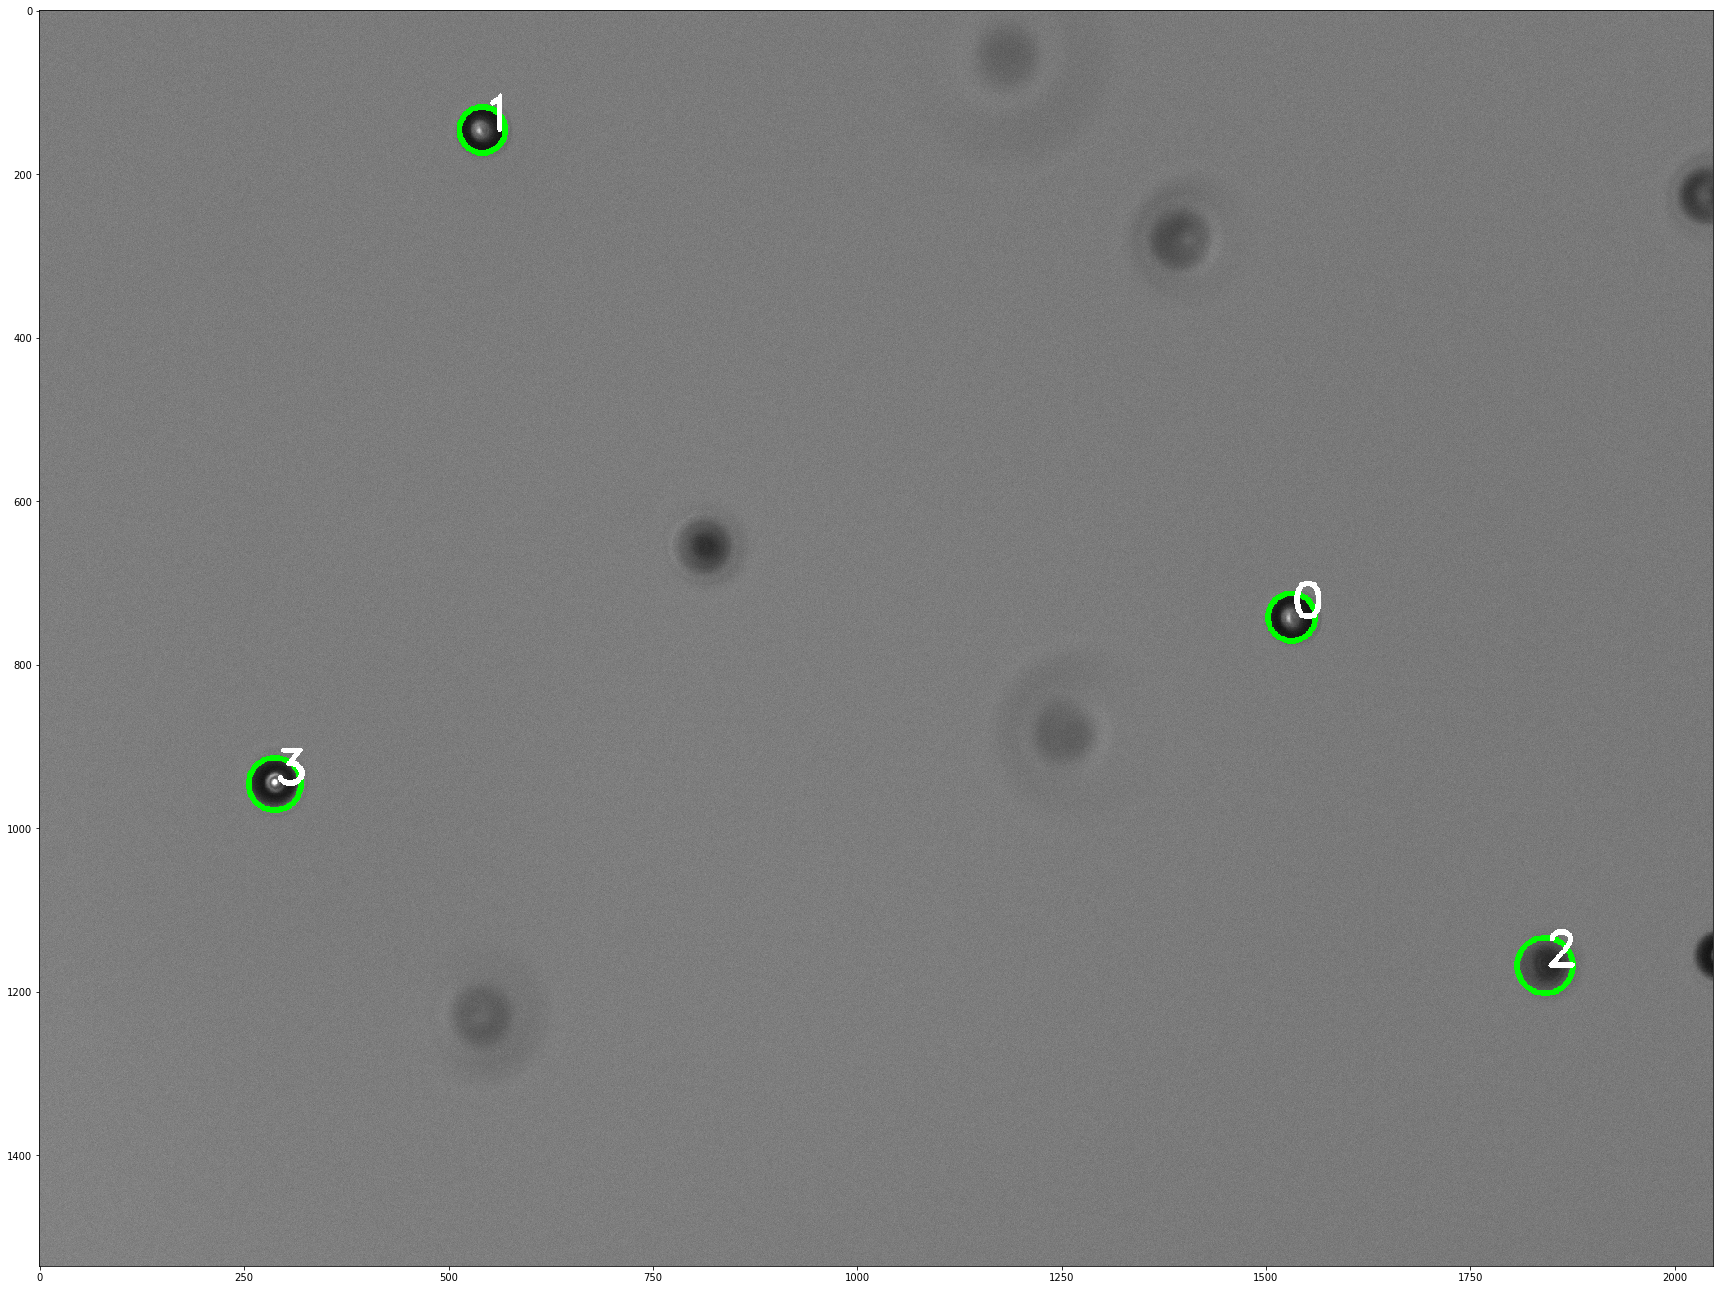

In [83]:
test_image_1 = ImageFile(
    '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images/Bbox_tests/',
    '26.5mm_53.6ul_254.5kHz-02122020182514-13.png')

# print(test_image_1)

test_image_1.find_droplets()

for droplet_index, droplet in enumerate(test_image_1.list_of_droplets):
    droplet.save_image()

path_to_diagnostics = test_image_1.path + 'Diagnostics'

out = test_image_1.make_diagnostic_image(save_path=path_to_diagnostics)
print(np.shape(out))

plt.figure(figsize=[30, 30])
plt.imshow(out)

110

/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	2020-04-02T12:44:15.914681	0	(952, 450)	29	None
/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	2020-04-02T12:44:15.914796	1	(1192, 948)	29	None
/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images	2020-04-02T12:44:15.914878	2	(1832, 706)	32	None


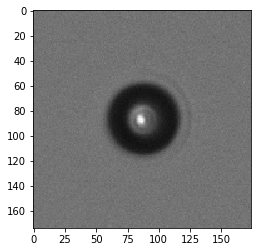

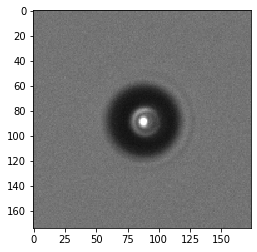

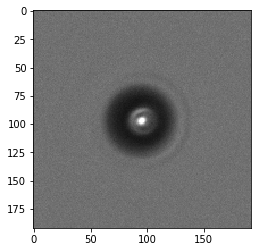

In [5]:
cwd = os.getcwd()
path_to_create = '/'.join([cwd, 'Results'])
os.makedirs(path_to_create, exist_ok=True)

test_image_2 = ImageFile(
    '/Users/olofjonsson/Projects/Ice/Droplet_codes/Preprocessing/Test_Images',
    '26.5mm_53.6ul_254.5kHz-02122020182515-19.png')
test_image_2.find_droplets()

for i in test_image_2.list_of_droplets:
    plt.figure()
    plt.imshow(i.image)
    i.gen_descriptor('Full')
    print(i.desc_string)

In [ ]:
# ANALYSIS 11 March

current_path = cwd = os.getcwd()

directories_with_inputs = ['200311/In_focus',
                           '200311/In_focus_changing_setting',
                           '200311/Many_defocussed',
                           '200311/Scans']


for directory_with_input_index, directory_with_input in enumerate(directories_with_inputs):
    path_to_files = '/'.join([current_path, directory_with_input])
    path_to_results = '/'.join([cwd, 'Results_' + directory_with_input])
    os.makedirs(path_to_results, exist_ok=True)

    list_of_files = [my_file for my_file in os.listdir(
        path_to_files) if not my_file.startswith('.')]  # to avoid hidden files like .DS_file
    print(directory_with_input+':')
    print('found {0} files'.format(str(len(list_of_files))))
    list_of_files.sort()
    print('sorted')

    list_of_files_to_do = list_of_files.copy()[0:2000]

    list_of_image_files = []

    for file_index, file_name in enumerate(list_of_files_to_do):
        # print(file_name)
        temp_file = ImageFile(path_to_files, file_name)
        list_of_image_files.append(temp_file)
        temp_file.find_droplets()

        if temp_file.contains_droplets:
            # print(file_name)
            for i in temp_file.list_of_droplets:
                i.gen_descriptor('Full')
                i.set_path(path_to_results)
                # print(i.desc_string)
                i.save_image(extra=temp_file.name)
                
        path_to_diagnostics = path_to_results + '/Diagnostics'
        out = temp_file.make_diagnostic_image(save_path=path_to_diagnostics)

        del temp_file

        # print(i.desc_string)
        # else:
        #    print('No droplets in {0}'.format(file_name))

In [ ]:
# ANALYSIS 12 march, DIAGNOSTICS

current_path = cwd = os.getcwd()

'''directories_with_inputs = ['1mm_55.1ul_223.4kHz_focus´2_100shots',
                           '1mm_55.1ul_223.4kHz_focus1_100shots',
                           '11mm_55.5ul_223.4kHz',
                           '16mm_55.7ul_223.4kHz',
                           '20mm_55.8ul_223.4kHz',
                           '25mm_55.8ul_223.4kHz',
                           '30mm_55.8ul_223.4khz',
                           '35mm_55.8ul_223.4khz',
                           '37.5mm_55.8ul_223.4khz',
                           '42.5mm_55.8ul_223.4khz',
                           '45mm_55.8ul_223.4khz',
                           '47.5mm_55.5ul_223.4khz',
                           '50mm_55.8ul_223.4khz']
'''

directories_with_inputs = ['47.5mm_55.5ul_223.4khz']


for directory_with_input_index, directory_with_input in enumerate(directories_with_inputs):
    path_to_files = '/'.join([current_path, directory_with_input])
    path_to_results = '/'.join([cwd, 'Results_' + directory_with_input])
    os.makedirs(path_to_results, exist_ok=True)

    list_of_files = [my_file for my_file in os.listdir(
        path_to_files) if not my_file.startswith('.')]  # to avoid hidden files like .DS_file
    print(directory_with_input+':')
    print('found {0} files'.format(str(len(list_of_files))))
    list_of_files.sort()
    print('sorted')

    list_of_files_to_do = list_of_files.copy()[0:2000]

    list_of_image_files = []

    for file_index, file_name in enumerate(list_of_files_to_do):
        # print(file_name)
        temp_file = ImageFile(path_to_files, file_name)
        list_of_image_files.append(temp_file)
        temp_file.find_droplets()

        if temp_file.contains_droplets:
            # print(file_name)
            for i in temp_file.list_of_droplets:
                i.gen_descriptor('Full')
                i.set_path(path_to_results)
                
        path_to_diagnostics = path_to_results + '/Diagnostics'
        out = temp_file.make_diagnostic_image(save_path=path_to_diagnostics)



        del temp_file

        # print(i.desc_string)
        # else:
        #    print('No droplets in {0}'.format(file_name))

In [6]:
# ANALYSIS 12 march, final and complete

current_path = cwd = os.getcwd()

directories_with_inputs = ['1mm_55.1ul_223.4kHz_focus´2_100shots',
                           '1mm_55.1ul_223.4kHz_focus1_100shots',
                           '11mm_55.5ul_223.4kHz',
                           '16mm_55.7ul_223.4kHz',
                           '20mm_55.8ul_223.4kHz',
                           '25mm_55.8ul_223.4kHz',
                           '30mm_55.8ul_223.4khz',
                           '35mm_55.8ul_223.4khz',
                           '37.5mm_55.8ul_223.4khz',
                           '42.5mm_55.8ul_223.4khz',
                           '45mm_55.8ul_223.4khz',
                           '47.5mm_55.5ul_223.4khz',
                           '50mm_55.8ul_223.4khz']


for directory_with_input_index, directory_with_input in enumerate(directories_with_inputs):
    path_to_files = '/'.join([current_path, directory_with_input])
    path_to_results = '/'.join([cwd, 'Results_' + directory_with_input])
    os.makedirs(path_to_results, exist_ok=True)

    list_of_files = [my_file for my_file in os.listdir(
        path_to_files) if not my_file.startswith('.')]  # to avoid hidden files like .DS_file
    print(directory_with_input+':')
    print('found {0} files'.format(str(len(list_of_files))))
    list_of_files.sort()
    print('sorted')

    list_of_files_to_do = list_of_files.copy()[0:2000]

    list_of_image_files = []

    for file_index, file_name in enumerate(list_of_files_to_do):
        # print(file_name)
        temp_file = ImageFile(path_to_files, file_name)
        list_of_image_files.append(temp_file)
        temp_file.find_droplets()

        if temp_file.contains_droplets:
            # print(file_name)
            for i in temp_file.list_of_droplets:
                i.gen_descriptor('Full')
                i.set_path(path_to_results)
                # print(i.desc_string)
                i.save_image(extra=temp_file.name)

        del temp_file

        # print(i.desc_string)
        # else:
        #    print('No droplets in {0}'.format(file_name))

40mm_55.8ul_223.4khz:
found 1500 files
sorted
47.5mm_55.5ul_223.4khz:
found 1500 files
sorted


In [ ]:
# ANALYSIS 9 march

current_path = cwd = os.getcwd()

directories_with_inputs = ['31.5mm_53.6ul_254.5kHz_1200frames_aborted_turbo_ffailure',
                           '34.0mm_53.6ul_254.5kHz_1200frames',
                           '37.0mm_53.6ul_254.5kHz_1200frames',
                           '38.0mm_53.6ul_254.5kHz_1200frames',
                           '39.0mm_53.6ul_254.5kHz_1200frames',
                           '40.0mm_53.6ul_254.5kHz_1200frames',
                           '41.5mm_53.6ul_254.5kHz_1200frames']

for directory_with_input_index, directory_with_input in enumerate(directories_with_inputs):
    path_to_files = '/'.join([current_path, directory_with_input])
    path_to_results = '/'.join([cwd, 'Results_' + directory_with_input])
    os.makedirs(path_to_results, exist_ok=True)

    list_of_files = [my_file for my_file in os.listdir(
        path_to_files) if not my_file.startswith('.')]  # to avoid hidden files like .DS_file

    print('found {0} files'.format(str(len(list_of_files))))
    list_of_files.sort()
    print('sorted')

    list_of_files_to_do = list_of_files.copy()[0:1200]

    '''list_of_files_to_do = ['41.5mm_53.6ul_254.5kHz-02122020183727-1.png',
                     '41.5mm_53.6ul_254.5kHz-02122020183728-5.png',
                     '41.5mm_53.6ul_254.5kHz-02122020183728-6.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184608-138.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184726-413.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184824-620.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184908-795.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184930-878.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184942-924.png',
                     '41.5mm_53.6ul_254.5kHz-02122020184958-990.png']
    '''
    list_of_image_files = []

    for file_index, file_name in enumerate(list_of_files_to_do):
        # print(file_name)
        temp_file = ImageFile(path_to_files, file_name)
        list_of_image_files.append(temp_file)
        temp_file.find_droplets()

        if temp_file.contains_droplets:
            # print(file_name)
            for i in temp_file.list_of_droplets:
                i.gen_descriptor('Full')
                i.set_path(path_to_results)
                # print(i.desc_string)
                i.save_image(extra=temp_file.name)

        del temp_file

        # print(i.desc_string)
        # else:
        #    print('No droplets in {0}'.format(file_name))

In [ ]:
for i in list_of_image_files:
    print(i.contains_droplets)

In [ ]:
i.list_of_droplets[0].position

In [ ]:
i.list_of_droplets[0].radius

In [ ]:
# print(list_of_files)

In [ ]:
'''
TODO

make a good radius check in the right place
check what we get




'''

In [ ]:
[my_file for my_file in list_of_files[0:10] if not my_file.startswith('.')]

In [ ]:
list_of_files[0].startswith('.')

In [ ]:
list_of_image_files[1].in_img.shape

In [ ]:
list_of_image_files[57].list_of_droplets[0].position

In [ ]:
list_of_image_files[57].list_of_droplets[0].radius*3

In [ ]:
np.add([1412, 1516], 66)